In [69]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
import importlib
from cycler import cycler
from pathlib import Path
from matplotlib.ticker import MultipleLocator
from pathlib import Path
from numpy.polynomial.polynomial import Polynomial
import re
from scipy.integrate import simpson
from matplotlib.lines import Line2D
from scipy.constants import e as q_e, m_e

# import utils
# importlib.reload(utils)

In [70]:
contact_potential = 2.01 # V (from Task 1)

In [71]:
file_paths = ['Data/task 2 32C.csv', 'Data/task 2 74.1C.csv']
columns = ['Counter Voltage', 'Detector Voltage (6V)', 'Detector Voltage (9V)', 'Detector Voltage (12V)']

data_dict = {}
internal_resistance = 27 # Ohm

for path in file_paths:
    #Read data
    df = pd.read_csv(path, header=None, names=columns)

    # Extract temperature from filename
    temp_key = re.search(r'task 2 (\d+\.?\d*)C', path).group(1)
    data_dict[f'{temp_key} C'] = df
    for v in (6, 9, 12):
        col_V = f'Detector Voltage ({v}V)'
        col_I = f'Current ({v}V)'
        data_dict[f'{temp_key} C'][col_I] = df[col_V] / internal_resistance

In [72]:
def fit_func(x, a, b, c, d, e):
    return a + b * x + c * x**2 + d * x**3 + e * x**4

parameter_dict ={}

# Fit the function to the data
for key, data in data_dict.items():
    parameter_dict[key] = {}

    # Iterate over the different detector voltages
    for v in 6, 9, 12:

        x_data = data['Counter Voltage'].values
        y_data = data[f'Current ({v}V)'].values

        # Remove NaN values
        mask = ~np.isnan(y_data)
        x_data = x_data[mask]
        y_data = y_data[mask]

        # Fit the polynomial function to the data
        popt, pcov = curve_fit(fit_func, x_data, y_data)
        # Extract the coefficients
        a, b, c, d, e = popt
        parameter_dict[key][f'{v}V'] = {
                'a': a,
                'b': b,
                'c': c,
                'd': d,
                'e': e
        }
        # Plot the original data and the fitted curve


In [73]:
print(parameter_dict)

{'32 C': {'6V': {'a': np.float64(0.19589094333390655), 'b': np.float64(-0.03015916044171153), 'c': np.float64(0.009652845545620431), 'd': np.float64(-0.003497045864671762), 'e': np.float64(0.00030896610228230994)}, '9V': {'a': np.float64(0.3170624522208474), 'b': np.float64(-0.040772422727833456), 'c': np.float64(0.011614599531911058), 'd': np.float64(-0.002376530188490109), 'e': np.float64(0.0001296961040992239)}, '12V': {'a': np.float64(0.41133677317690803), 'b': np.float64(-0.02096301058359479), 'c': np.float64(0.0005676720611919802), 'd': np.float64(-7.743028125757614e-05), 'e': np.float64(-8.106616204650131e-06)}}, '74.1 C': {'6V': {'a': np.float64(0.1360448952688404), 'b': np.float64(-0.018114647263488434), 'c': np.float64(-0.00012496566418436088), 'd': np.float64(-0.0007000429136461623), 'e': np.float64(0.00010031466223826755)}, '9V': {'a': np.float64(0.2338355894682286), 'b': np.float64(-0.040385158170520165), 'c': np.float64(0.007582101661989474), 'd': np.float64(-0.0013111845

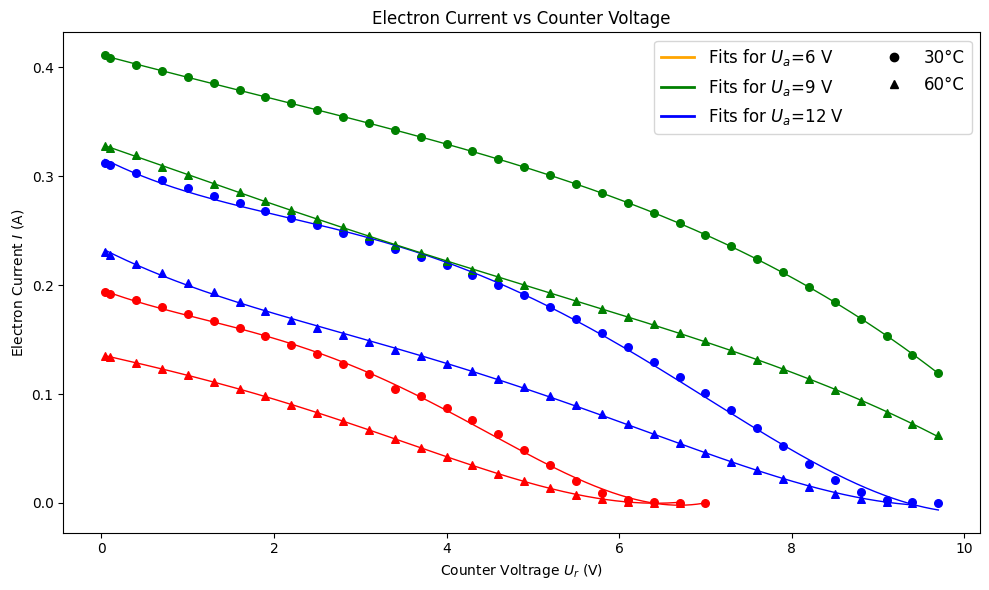

In [74]:
color = {6: 'red', 9: 'blue', 12: 'green'}
mark = {'32 C': 'o', '74.1 C': '^'}

fig, ax = plt.subplots(figsize=(10, 6))

ax.set(xlabel='Counter Voltrage $U_r$ (V)',
       ylabel='Electron Current $I$ (A)',
       title='Electron Current vs Counter Voltage')

# Plot the data points
for key, data in data_dict.items():
    x_all = data['Counter Voltage'].values
    for v in 6, 9, 12:
        y_all = data[f'Current ({v}V)'].values
        # Remove NaN values
        mask = ~np.isnan(y_all)
        x_filtered = x_all[mask]
        #y_filtered = y_all[mask]
        x_fine = np.linspace(x_filtered.min(), x_filtered.max(), 1000)

        col_I = data[f'Current ({v}V)']
        col_V = data['Counter Voltage']
        ax.scatter(col_V, col_I,
                   color=color[v],
                   marker=mark[key],
                   label=f'{key}, {v}V',
                   s=30
        )
        y_values = fit_func(x_fine, *parameter_dict[key][f'{v}V'].values())
        ax.plot(x_fine, y_values, 
                color=color[v],
                linestyle='-',
                lw=1,
                label=f'{key} fit, {v}V'
        )

# Custom legend for fits (color lines by U_a)
fit_lines = [
    Line2D([0], [0], color='orange', lw=2, label=r'Fits for $U_a$=6 V'),
    Line2D([0], [0], color='green',  lw=2, label=r'Fits for $U_a$=9 V'),
    Line2D([0], [0], color='blue',   lw=2, label=r'Fits for $U_a$=12 V'),
]

# Custom legend for temperatures (marker shape)
temp_markers = [
    Line2D([0], [0], color='black', marker='o', linestyle='None', label='30°C'),
    Line2D([0], [0], color='black', marker='^', linestyle='None', label='60°C'),
]

# Add both groups to the legend
legend_elements = fit_lines + temp_markers
ax.legend(handles=legend_elements, loc='best', fontsize=12, ncol=2)
plt.tight_layout()
plt.show()


In [75]:
# Flatten the nested parameter_dict into a list of records
records = []
for temp, sub in parameter_dict.items():
    for volt, coeffs in sub.items():
        row = {
            'Temperature': temp,
            'Voltage': volt,
            'Voltage_num': int(volt.rstrip('V'))  # extract numeric voltage
        }
        row.update(coeffs)  # Adds keys a, b, c, d, e
        records.append(row)

# Create DataFrame
df = pd.DataFrame.from_records(records)

# Sort properly: first by Temperature, then numeric Voltage
df = df.sort_values(by=['Temperature', 'Voltage_num']).drop(columns='Voltage_num')

# Optional: format floats
pd.set_option('display.float_format', '{:.4e}'.format)

# Display in Jupyter
display(df)


,Temperature,Voltage,a,b,c,d,e
0,32 C,6V,1.9589e-01,-3.0159e-02,9.6528e-03,-3.4970e-03,3.0897e-04
1,32 C,9V,3.1706e-01,-4.0772e-02,1.1615e-02,-2.3765e-03,1.2970e-04
2,32 C,12V,4.1134e-01,-2.0963e-02,5.6767e-04,-7.7430e-05,-8.1066e-06
3,74.1 C,6V,1.3604e-01,-1.8115e-02,-1.2497e-04,-7.0004e-04,1.0031e-04
4,74.1 C,9V,2.3384e-01,-4.0385e-02,7.5821e-03,-1.3112e-03,7.2128e-05
5,74.1 C,12V,3.2921e-01,-2.7657e-02,-2.9750e-04,2.0286e-04,-1.7769e-05


## For plotting with contact potential subtracted

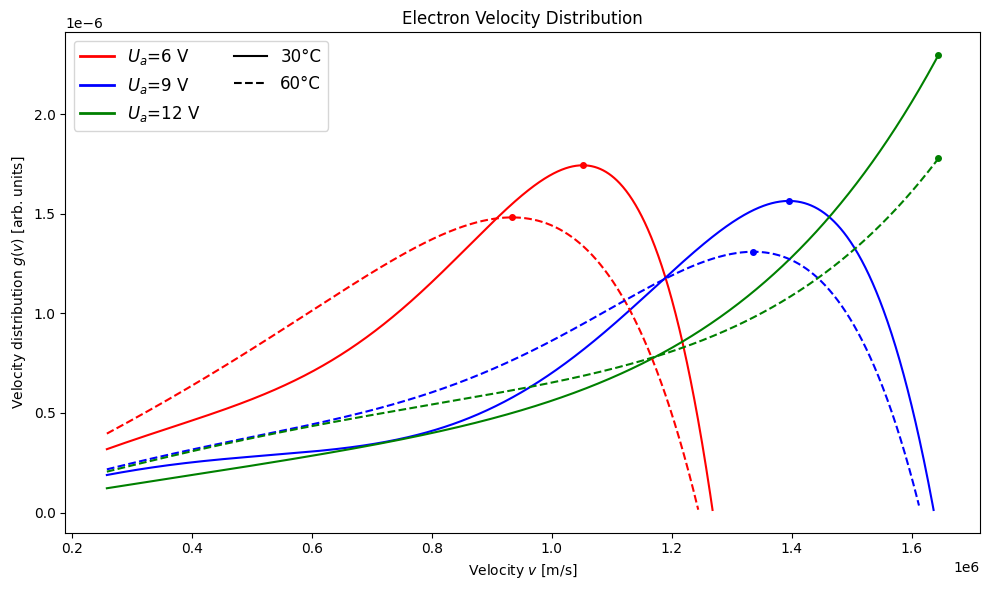

In [76]:
distros = {}
max_velocities = {}
for key, data in data_dict.items():
    x_all = data['Counter Voltage'].values - contact_potential
    distros[key] = {}
    max_velocities[key] = {}
    for v in (6, 9, 12):
        y_col=f'Current ({v}V)'
        mask = ~np.isnan(data[y_col].values)
        x, I = x_all[mask], data[y_col].values[mask]

        mask2 = x > 0
        x, I = x[mask2], I[mask2]

        p = Polynomial.fit(x, I, 4)
        dp = p.deriv()
        
        #high-res grid for smooth curve
        x_fine = np.linspace(x.min(), x.max(), 1000)

        # Calculate velocity grid and distribution
        # Note: x_fine is in volts, so we use q_e for electron charge
        # and m_e for electron mass
        v_grid = np.sqrt(2 * q_e * x_fine / m_e)  # x_fine is in volts
        fU = -dp(x_fine)
        fU[fU < 0] = 0

        # Normalize area to 1 (unsure why)
        area = simpson(fU, x_fine)
        fU_norm = fU / area

        g_v = fU_norm * (m_e * v_grid / q_e)  # convert to velocity distribution
        # Threshold to determine where the tail starts (e.g. 0.5% of max)
        threshold = 0.005 * np.max(g_v)
        max_idx = np.argmax(g_v)

        # Start searching after the peak
        for i in range(max_idx + 1, len(g_v)):
            if g_v[i] < threshold:
                # Optional: only trim if it stays low for several points
                if np.all(g_v[i:i+5] < threshold):
                    g_v = g_v[:i]
                    v_grid = v_grid[:i]
                    break
        distros[key][v] = (x_fine, fU_norm, v_grid, g_v)


# Legend for voltages
voltage_legend = [
    Line2D([0], [0], color='red', lw=2, label=r'$U_a$=6 V'),
    Line2D([0], [0], color='blue', lw=2, label=r'$U_a$=9 V'),
    Line2D([0], [0], color='green', lw=2, label=r'$U_a$=12 V')
]

# Legend for temperatures
temperature_legend = [
    Line2D([0], [0], color='black', linestyle='-', label='30°C'),
    Line2D([0], [0], color='black', linestyle='--', label='60°C')
]

fig, ax = plt.subplots(figsize=(10, 6))
ax.set(xlabel=r'Velocity $v$ [m/s]',
       ylabel=r'Velocity distribution $g(v)$ [arb. units]',
       title='Electron Velocity Distribution')

for key, data in distros.items():
    for v, (x, f, v_grid, g_v) in data.items():
        ax.plot(v_grid, g_v,
                color=color[v],
                linestyle='-' if key=='32 C' else '--',
                label=f'{key}, {v}V'
    )
        max_idx = np.argmax(g_v)
        ax.plot(v_grid[max_idx], g_v[max_idx],
        marker='o', color=color[v], markersize=4)

        max_velocities[key][v] = v_grid[max_idx]

# Add both legends to the plot
legend_elements = voltage_legend + temperature_legend
ax.legend(handles=legend_elements, loc='best', fontsize=12, ncol=2)

plt.tight_layout()
plt.show()        
    


In [84]:
for key, data in max_velocities.items():
    print(f'{key}:')
    for v, max_v in data.items():
        print(f'  {v}: {max_v:.3e} m/s')

32 C:
  6: 1.303e+06 m/s
  9: 1.617e+06 m/s
  12: 1.847e+06 m/s
74.1 C:
  6: 1.212e+06 m/s
  9: 1.557e+06 m/s
  12: 1.847e+06 m/s


## For plotting without contact potential subtracted. 
Need to comment out above and rerun for it to work because I'm too lazy to rewrite it right now. (uses truncated data from above)

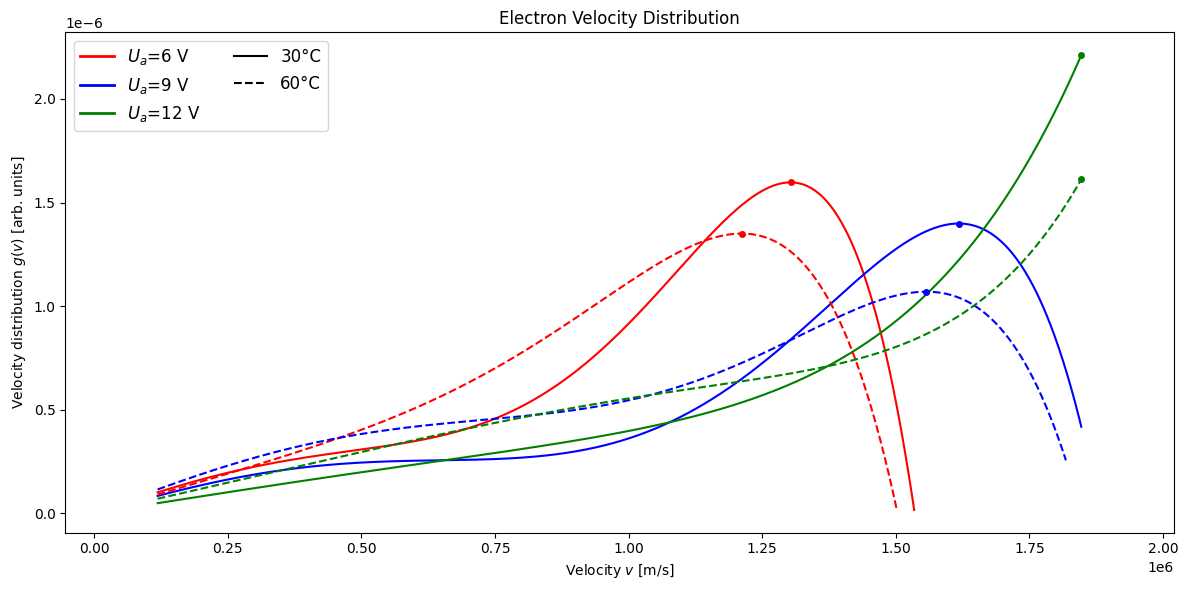

In [ ]:
distros = {}
max_velocities = {}
for key, data in data_dict.items():
    x_all = data['Counter Voltage'].values #- contact_potential
    distros[key] = {}
    max_velocities[key] = {}
    for v in (6, 9, 12):
        y_col=f'Current ({v}V)'
        mask = ~np.isnan(data[y_col].values)
        x, I = x_all[mask], data[y_col].values[mask]

        # mask2 = x > 0
        # x, I = x[mask2], I[mask2]

        p = Polynomial.fit(x, I, 4)
        dp = p.deriv()
        
        #high-res grid for smooth curve
        x_fine = np.linspace(x.min(), x.max(), 1000)

        # Calculate velocity grid and distribution
        # Note: x_fine is in volts, so we use q_e for electron charge
        # and m_e for electron mass
        v_grid = np.sqrt(2 * q_e * x_fine / m_e)  # x_fine is in volts
        fU = -dp(x_fine)
        fU[fU < 0] = 0

        # Normalize area to 1 (unsure why)
        area = simpson(fU, x_fine)
        fU_norm = fU / area

        g_v = fU_norm * (m_e * v_grid / q_e)  # convert to velocity distribution
        # Threshold to determine where the tail starts (e.g. 0.5% of max)
        threshold = 0.005 * np.max(g_v)
        max_idx = np.argmax(g_v)

        # Start searching after the peak
        for i in range(max_idx + 1, len(g_v)):
            if g_v[i] < threshold:
                # Optional: only trim if it stays low for several points
                if np.all(g_v[i:i+5] < threshold):
                    g_v = g_v[:i]
                    v_grid = v_grid[:i]
                    break
        distros[key][v] = (x_fine, fU_norm, v_grid, g_v)


# Legend for voltages
voltage_legend = [
    Line2D([0], [0], color='red', lw=2, label=r'$U_a$=6 V'),
    Line2D([0], [0], color='blue', lw=2, label=r'$U_a$=9 V'),
    Line2D([0], [0], color='green', lw=2, label=r'$U_a$=12 V')
]

# Legend for temperatures
temperature_legend = [
    Line2D([0], [0], color='black', linestyle='-', label='30°C'),
    Line2D([0], [0], color='black', linestyle='--', label='60°C')
]

fig, ax = plt.subplots(figsize=(12, 6))
ax.set(xlabel=r'Velocity $v$ [m/s]',
       ylabel=r'Velocity distribution $g(v)$ [arb. units]',
       title='Electron Velocity Distribution')

for key, data in distros.items():
    for v, (x, f, v_grid, g_v) in data.items():
        ax.plot(v_grid, g_v,
                color=color[v],
                linestyle='-' if key=='32 C' else '--',
                label=f'{key}, {v}V'
    )
        max_idx = np.argmax(g_v)
        ax.plot(v_grid[max_idx], g_v[max_idx],
        marker='o', color=color[v], markersize=4)

        max_velocities[key][v] = v_grid[max_idx]

# Add both legends to the plot
legend_elements = voltage_legend + temperature_legend
ax.legend(handles=legend_elements, loc='best', fontsize=12, ncol=2)
ax.margins(x=0.1)
plt.tight_layout()
plt.show()        
    


In [79]:
for key, data in max_velocities.items():
    print(f'{key}:')
    for v, max_v in data.items():
        print(f'  {v}: {max_v:.3e} m/s')

32 C:
  6: 1.303e+06 m/s
  9: 1.617e+06 m/s
  12: 1.847e+06 m/s
74.1 C:
  6: 1.212e+06 m/s
  9: 1.557e+06 m/s
  12: 1.847e+06 m/s


In [80]:
print(f"{key}, {v}V: v_grid min = {v_grid.min():.2e}")


74.1 C, 12V: v_grid min = 1.19e+05
